In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime, timedelta

pd.set_option('display.max_rows', 120)
pd.set_option('display.max_columns', 120)

%load_ext autoreload
%autoreload 2
from utils import show_heat_map, print_mutual_info, aggregate_data, resample_df, load_big_df
from utils import two_sig_signal, two_sig_signal_multi, get_yulu_df

In [54]:
def resample_df_a(df_buy, df_sell, df_ob, time_step):
    df_buy_resampled = df_buy.resample(time_step).agg({
            'trade_size_sum': 'sum',  # Sum for size
            'trade_price_min': 'min',  # Min for min price
            'trade_price_max': 'max'   # Max for max price
        }).rename(columns={'trade_size_sum': 'buy_size', 'trade_price_min': 'buy_price_min',  'trade_price_max': 'buy_price_max'})
    df_sell_resampled = df_sell.resample(time_step).agg({
            'trade_size_sum': 'sum',  # Sum for size
            'trade_price_min': 'min',  # Min for min price
            'trade_price_max': 'max'   # Max for max price
        }).rename(columns={'trade_size_sum': 'sell_size', 'trade_price_min': 'sell_price_min',  'trade_price_max': 'sell_price_max'})
    df_ob_resampled = df_ob.resample(time_step).last()
    df = df_ob_resampled.join(df_buy_resampled.join(df_sell_resampled, how='outer'), how='outer')

    for col in ['buy_size', 'sell_size']:
        df[col] = df[col].fillna(0)

    for col in ['mid']:
        df[col] = df[col].ffill()  

    return df

In [93]:
df_raw = pd.read_csv("../simulation_data/output_2025-04-08_20250401_USUALUSDTOB500_USUALUSDTtrades_PL.csv")
df_buy, df_sell, df_ob = aggregate_data(df_raw)
# df = resample_df(df_buy, df_sell, df_ob, '1T')
df_raw

,time,bbid,bask,bsize,asize,trade_side,trade_size,trade_price
0,2025-04-01 00:00:00.170000128,0.1221,0.1222,50.0,76750.0,NaN,NaN,NaN
1,2025-04-01 00:00:00.269999872,0.1221,0.1222,50.0,80008.0,NaN,NaN,NaN
2,2025-04-01 00:00:00.369999872,0.1221,0.1222,50.0,80780.0,NaN,NaN,NaN
3,2025-04-01 00:00:01.069999872,0.1221,0.1222,50.0,80780.0,NaN,NaN,NaN
4,2025-04-01 00:00:01.470000128,0.1221,0.1222,50.0,80780.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
429775,2025-04-01 23:59:58.869999872,0.1197,0.1198,602.0,31098.0,NaN,NaN,NaN
429776,2025-04-01 23:59:59.170000128,0.1197,0.1198,602.0,31098.0,NaN,NaN,NaN
429777,2025-04-01 23:59:59.670000128,0.1197,0.1198,602.0,31098.0,NaN,NaN,NaN
429778,2025-04-02 00:00:00.068999936,0.1197,0.1198,602.0,31098.0,NaN,NaN,NaN


In [56]:
df_raw['bbid'] = df_raw['bbid'].ffill()
df_raw['bask'] = df_raw['bask'].ffill()
trades = df_raw[(df_raw['trade_side'] == 'Buy') | (df_raw['trade_side'] == 'Sell')].reset_index(drop=True)
trades['balance'] = 0
trades

,time,bbid,bask,trade_side,trade_size,trade_price,balance
0,2025-04-01 00:00:11.163200000,0.1221,0.1222,Sell,50.0,0.1221,0
1,2025-04-01 00:00:33.962099968,0.1221,0.1222,Sell,7753.0,0.1221,0
2,2025-04-01 00:00:33.965799936,0.1221,0.1222,Sell,1247.0,0.1221,0
3,2025-04-01 00:00:39.082299904,0.1220,0.1221,Sell,50.0,0.1220,0
4,2025-04-01 00:00:39.082299904,0.1220,0.1221,Sell,243.0,0.1220,0
...,...,...,...,...,...,...,...
20216,2025-04-01 23:57:16.076600064,0.1197,0.1198,Sell,621.0,0.1197,0
20217,2025-04-01 23:58:13.969299968,0.1197,0.1198,Buy,158.0,0.1198,0
20218,2025-04-01 23:58:13.969299968,0.1197,0.1198,Buy,463.0,0.1198,0
20219,2025-04-01 23:58:39.787100160,0.1197,0.1198,Sell,51.0,0.1197,0


-1.656 bps
cost: -1655.671
valume: 170K


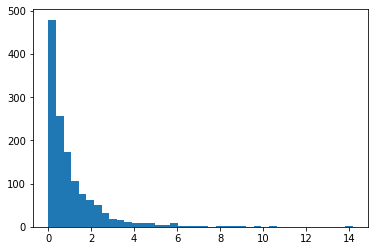

Holding: 0.6086866645333334 1.0728264615962217 1.3882626916777836


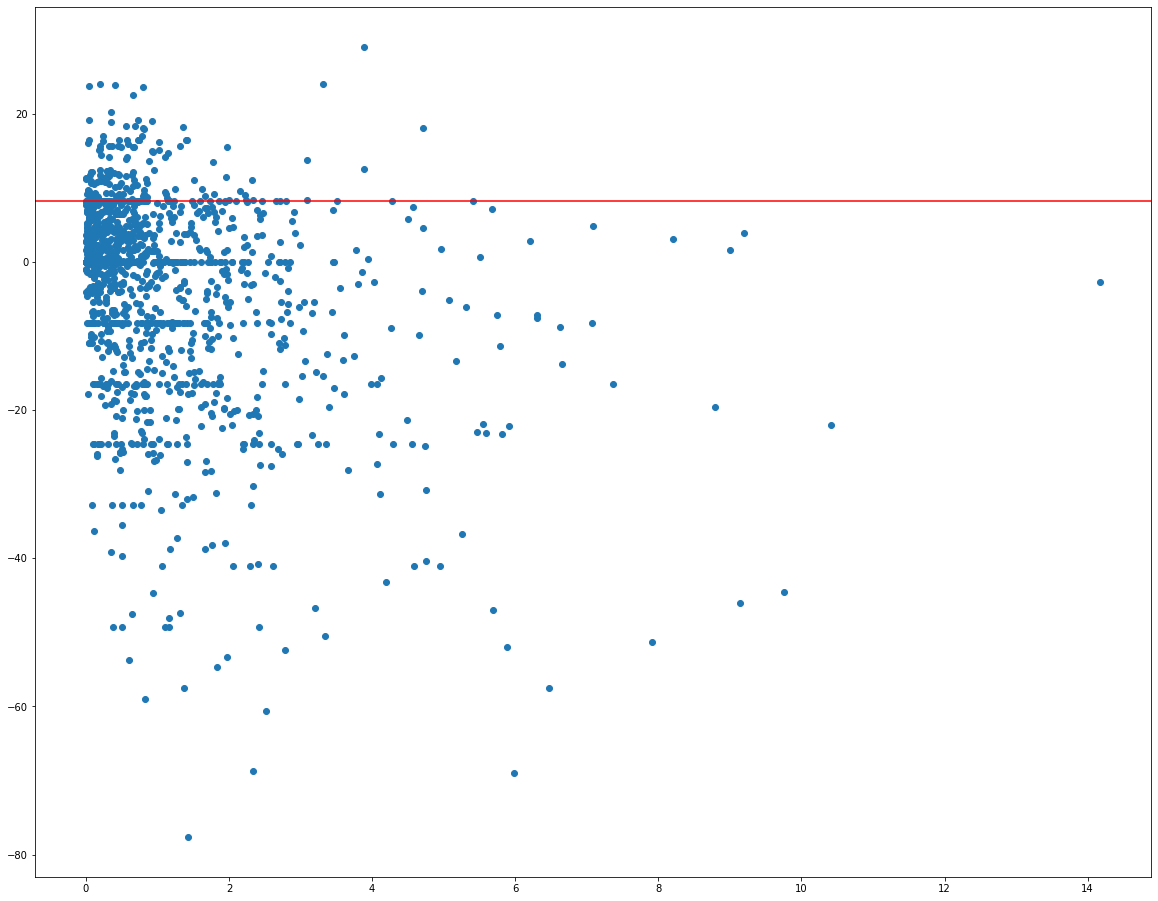

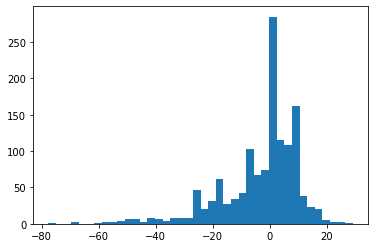

,time,bbid,bask,trade_side,trade_size,trade_price,balance,tot_volume,position,exch_bids,exch_asks,pnl,pos_change,per_trade_pnl
0,2025-04-01 00:00:00.170000128,0.1221,0.1222,NaN,NaN,NaN,0.0000,0.0000,0.0,"(None, 0)","(None, 0)",0.0000,1,NaN
1,2025-04-01 00:00:00.269999872,0.1221,0.1222,NaN,NaN,NaN,0.0000,0.0000,0.0,"(0.1221, 500)","(0.1222, 500)",0.0000,0,NaN
2,2025-04-01 00:00:00.369999872,0.1221,0.1222,NaN,NaN,NaN,0.0000,0.0000,0.0,"(0.1221, 500)","(0.1222, 500)",0.0000,0,NaN
3,2025-04-01 00:00:01.069999872,0.1221,0.1222,NaN,NaN,NaN,0.0000,0.0000,0.0,"(0.1221, 500)","(0.1222, 500)",0.0000,0,NaN
4,2025-04-01 00:00:01.470000128,0.1221,0.1222,NaN,NaN,NaN,0.0000,0.0000,0.0,"(0.1221, 500)","(0.1222, 500)",0.0000,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
429775,2025-04-01 23:59:58.869999872,0.1197,0.1198,NaN,NaN,NaN,-84.6571,169931.6727,472.0,"(0.1197, 28.0)","(0.1198, 972.0)",-28.1351,0,NaN
429776,2025-04-01 23:59:59.170000128,0.1197,0.1198,NaN,NaN,NaN,-84.6571,169931.6727,472.0,"(0.1197, 28.0)","(0.1198, 972.0)",-28.1351,0,NaN
429777,2025-04-01 23:59:59.670000128,0.1197,0.1198,NaN,NaN,NaN,-84.6571,169931.6727,472.0,"(0.1197, 28.0)","(0.1198, 972.0)",-28.1351,0,NaN
429778,2025-04-02 00:00:00.068999936,0.1197,0.1198,NaN,NaN,NaN,-84.6571,169931.6727,472.0,"(0.1197, 28.0)","(0.1198, 972.0)",-28.1351,0,NaN


In [91]:
df_raw['bbid'] = df_raw['bbid'].ffill()
df_raw['bask'] = df_raw['bask'].ffill()

MAX_POSITION = 500
ROUND_TRIP_LATENCY = timedelta(milliseconds=80)
MAKER_FEE_BPS = 0
TAKER_FEE_BPS = 0
MARKET_EXIT_TIME = timedelta(minutes=900)

balance = []
position = []
tot_volume = []

exch_bids = []
exch_asks = []

curr_pos = 0
curr_balance = 0

last_enter_time = None


# simulate latency
# 2 unit wide quotes

class Queue:
    def __init__(self):
        self.list = []
        self.ptr = 0

    def push(self, x):
        self.list.append(x)
    
    def pop(self):
        ret = self.list[self.ptr]
        self.ptr += 1
        return ret
    
    def front(self):
        return self.list[self.ptr]
    
    def isEmpty(self):
        return len(self.list) <= self.ptr

order_queue = Queue() # (time, (bid_price, bid_qty), (ask_price, ask_qty))
prev_bbid = None
prev_bask = None

exch_bid = (None, 0) # price, qty
exch_ask = (None, 0) # price, qty

def send_order(bid_price, ask_price, curr_time, curr_position, order_queue):
    receive_time = curr_time + ROUND_TRIP_LATENCY
    new_order = (receive_time, (bid_price, MAX_POSITION - curr_position), (ask_price, MAX_POSITION + curr_position))
    order_queue.push(new_order)

# def get_new_price(exch_bid, exch_ask, bid, ask):
#     if exch_bid[0] is None or exch_ask[0] is None:
#         return True, bid - 0.0001, ask + 0.0001
#     if bid < exch_bid[0]:
#         return True, bid, max(bid + 0.0003, ask)
#     if ask > exch_ask[0]:
#         return True, min(ask - 0.0003, bid), ask
#     return False, exch_bid[0], exch_ask[0]

def get_new_price(exch_bid, exch_ask, bid, ask):
    return True, bid, ask

# def get_new_price(exch_bid, exch_ask, bid, ask):
#     return True, bid-0.0001, ask+0.0001

def is_enter(prev_pos, curr_pos):
    return np.sign(prev_pos) != np.sign(curr_pos)

for row in df_raw.itertuples():
    volume = 0

    while not order_queue.isEmpty():
        top_order = order_queue.front()
        if top_order[0] <= row.time:
            exch_bid = top_order[1]
            exch_ask = top_order[2]
            order_queue.pop()
        else:
            break
    
    # market exit
    if last_enter_time and row.time - last_enter_time > MARKET_EXIT_TIME and curr_pos != 0:
        
        if curr_pos > 0:
            curr_balance += curr_pos * row.bbid
            curr_balance -= curr_pos * row.bbid * 0.0001 * TAKER_FEE_BPS
            volume = curr_pos * row.bbid
        else:
            curr_balance += curr_pos * row.bask
            curr_balance -= abs(curr_pos) * row.bask * 0.0001 * TAKER_FEE_BPS
            volume = curr_pos * row.bask
        curr_pos = 0
        last_enter_time = None

    if row.trade_side == 'Sell':
        if row.trade_price <= exch_bid[0]:
            qty = min(row.trade_size, exch_bid[1])
            exch_bid = (exch_bid[0], exch_bid[1] - qty)

            if is_enter(curr_pos, curr_pos+qty):
                last_enter_time=row.time

            curr_pos += qty
            curr_balance -= exch_bid[0] * qty 
            curr_balance -= exch_bid[0] * qty * 0.0001 * MAKER_FEE_BPS
            volume = exch_bid[0] * qty

            (_, bid_price, ask_price) = get_new_price(exch_bid, exch_ask, prev_bbid, prev_bask)
            send_order(bid_price, ask_price, row.time, curr_pos, order_queue)

    elif row.trade_side == 'Buy':
        if row.trade_price >= exch_ask[0]:
            qty = min(row.trade_size, exch_ask[1])
            exch_ask = (exch_ask[0], exch_ask[1] - qty)
            # qty = max(-row.trade_size, -MAX_POSITION - curr_pos)

            if is_enter(curr_pos, curr_pos+qty):
                last_enter_time=row.time

            curr_pos -= qty
            curr_balance += exch_ask[0] * qty
            curr_balance -= exch_ask[0] * qty * 0.0001 * MAKER_FEE_BPS
            volume = exch_ask[0] * qty

            (_, bid_price, ask_price) = get_new_price(exch_bid, exch_ask, prev_bbid, prev_bask)
            send_order(bid_price, ask_price, row.time, curr_pos, order_queue)
    
    else:
        if (prev_bbid, prev_bask) != (row.bbid, row.bask):
            (prev_bbid, prev_bask) = (row.bbid, row.bask)

            (should_update, bid_price, ask_price) = get_new_price(exch_bid, exch_ask, prev_bbid, prev_bask)
            if should_update:
                send_order(bid_price, ask_price, row.time, curr_pos, order_queue)


    tot_volume.append(volume)
    balance.append(curr_balance)
    position.append(curr_pos)
    exch_bids.append(exch_bid)
    exch_asks.append(exch_ask)

df_raw['balance'] = balance
df_raw['tot_volume'] = tot_volume
df_raw['tot_volume'] = df_raw['tot_volume'].cumsum()

df_raw['position'] = position
df_raw['exch_bids'] = exch_bids
df_raw['exch_asks'] = exch_asks

df_raw['pnl'] = df_raw['balance'] + (df_raw['bbid'] + df_raw['bask']) / 2.0 * df_raw['position']
# df_raw['volume'] = abs(df_raw['balance'] - df_raw['balance'].shift(1)).cumsum()
# df_raw

bps_lost_per_volume = df_raw['pnl'].iloc[-1]/df_raw['tot_volume'].iloc[-1]
print(f"{bps_lost_per_volume * 10000:.3f} bps")
print(f"cost: {10_000_000 * bps_lost_per_volume:.3f}")
print(f"valume: {df_raw['tot_volume'].iloc[-1]/1000:.0f}K")

df_raw['pos_change'] = (np.sign(df_raw['position'].shift(1)) != np.sign(df_raw['position'])) * 1

hold_periods_mins = df_raw[df_raw['pos_change'] == 1]['time'].diff().dt.total_seconds() / 60
# print(hold_periods.dt.total_seconds())
plt.hist(hold_periods_mins, bins=40)
plt.show()
print("Holding:", hold_periods_mins.median(), hold_periods_mins.mean(), hold_periods_mins.std())


per_trade_pnl = df_raw[df_raw['pos_change'] == 1]['pnl'].diff()
per_trade_pnl_bps = per_trade_pnl / (500.0 * df_raw['bbid'].mean()) * 10000

plt.figure(figsize=(20, 16))
plt.scatter(x=hold_periods_mins, y= per_trade_pnl_bps)
plt.axhline(y=0.00081900081*10000, color='red')
# plt.figsize((12,8))
plt.show()
plt.hist(per_trade_pnl_bps, bins=40)
plt.show()

df_raw

In [129]:
display(df_raw.iloc[700:701])

,time,bbid,bask,trade_side,trade_size,trade_price,balance,position,pnl,volume,exch_bids,exch_asks,tot_volume
700,2025-04-01 00:03:00.470000128,0.1221,0.1222,NaN,NaN,NaN,-61.010496,500.0,0.064504,525.914341,"(0.122, 0.0)","(0.1222, 1000.0)",92.9821


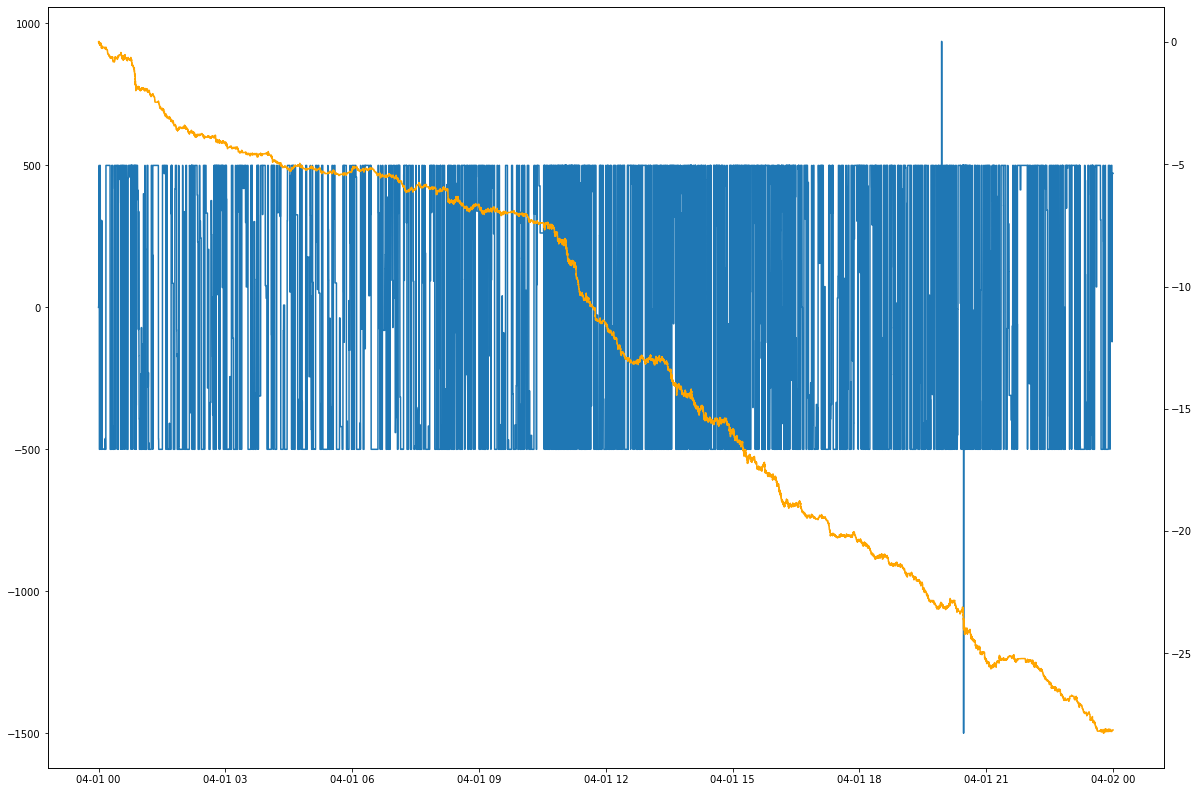

In [92]:
# a = 130000
# b = 140000

a = 0
b = -1

# plot_df = df_raw.set_index('time')
# plot_df[['position', 'pnl']].iloc[a:b].plot()

fig, ax1 = plt.subplots(figsize=(20, 14))

ax1.plot(df_raw.iloc[a:b]['time'], df_raw.iloc[a:b]['position'])
# ax1.scatter(df_raw[df_raw['pos_change'] == 1].iloc[a:b]['time'], df_raw[df_raw['pos_change'] == 1].iloc[a:b]['pos_change'])

ax2 = ax1.twinx()

ax2.plot(df_raw.iloc[a:b]['time'], df_raw.iloc[a:b]['pnl'], color='orange')

# plt.plot(df_raw.iloc[a:b]['time'], df_raw.iloc[a:b]['position'])
plt.show()

In [121]:
df_raw[(df_raw['trade_side'] == 'Buy') | (df_raw['trade_side'] == 'Sell')].head(50)

,time,bbid,bask,trade_side,trade_size,trade_price,balance,position,pnl,volume,exch_bids,exch_asks,tot_volume
49,2025-04-01 00:00:11.163200000,0.1221,0.1222,Sell,50.0,0.1221,-6.10122,50.0,0.00628,6.106221,"(0.122, 450.0)","(0.1223, 500)",6.1
136,2025-04-01 00:00:33.962099968,0.1221,0.1222,Sell,7753.0,0.1221,-61.01220,500.0,0.06280,61.062210,"(0.122, 0.0)","(0.1223, 550.0)",61.0
137,2025-04-01 00:00:33.965799936,0.1221,0.1222,Sell,1247.0,0.1221,-61.01220,500.0,0.06280,61.062210,"(0.122, 0.0)","(0.1223, 550.0)",61.0
158,2025-04-01 00:00:39.082299904,0.1220,0.1221,Sell,50.0,0.1220,-61.01220,500.0,0.01280,61.062210,"(0.122, 0.0)","(0.1223, 1000.0)",61.0
159,2025-04-01 00:00:39.082299904,0.1220,0.1221,Sell,243.0,0.1220,-61.01220,500.0,0.01280,61.062210,"(0.122, 0.0)","(0.1223, 1000.0)",61.0
161,2025-04-01 00:00:39.221900032,0.1220,0.1221,Sell,536.0,0.1220,-61.01220,500.0,0.01280,61.062210,"(0.122, 0.0)","(0.1223, 1000.0)",61.0
183,2025-04-01 00:00:49.000499968,0.1220,0.1221,Sell,829.0,0.1220,-61.01220,500.0,0.01280,61.062210,"(0.122, 0.0)","(0.1223, 1000.0)",61.0
227,2025-04-01 00:01:02.430400000,0.1219,0.1220,Buy,654.0,0.1220,-61.01220,500.0,-0.03720,140.834252,"(0.1219, 0.0)","(0.12219999999999999, 1000.0)",61.0
228,2025-04-01 00:01:02.430400000,0.1219,0.1220,Buy,1394.0,0.1220,-61.01220,500.0,-0.03720,183.037810,"(0.1219, 0.0)","(0.12219999999999999, 1000.0)",61.0
313,2025-04-01 00:01:34.576100096,0.1219,0.1220,Buy,668.0,0.1220,-61.01220,500.0,-0.03720,183.037810,"(0.1219, 0.0)","(0.12219999999999999, 1000.0)",61.0
